In [1]:
import pandas as pd
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
import numpy as np
from numpy import linalg as LA
from googletrans import Translator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import igraph.test
from igraph import *
import csv
import numpy as np
import networkx as nx
import operator
import copy
from IPython.core.display import display, SVG
import math

In [2]:
#!pip install textblob
#!pip install vaderSentiment
#!pip install googletrans

In [3]:
data = pd.read_csv(r"./Dataset/#AmazonFires_follower_followee_network.csv", encoding="utf-8")
data.tail()

,id,screen_name,followerIDs,friendIDs,followers_count,friends_count,name,location,account_created_at,verified
155,156,twilight2_0,"1193540232550977536, 3434786314, 7388069553014...","1193540232550977536, 3434786314, 1194356369874...",2581,3034,in honor of Big Bill Haywood!,"Chicago, IL",2016-10-06 02:41:39,False
156,157,gramsci1937,"1193540232550977536, 1161827557882437632, 1244...","1193540232550977536, 1161827557882437632, 2403...",3832,4107,Emily S. Matthis 🌹🏴,"Bruges, Belgium",2016-05-24 21:59:20,False
157,158,StinsonTimothy,"101272741, 2983250529, 1184187948440473601, 89...","15164565, 16955991, 15155640, 5743162, 1865009...",103,168,Timothy Stinson,NaN,2018-11-09 02:10:38,False
158,159,RTBayArea,"141392441, 1053431454317797377, 147089523, 109...","1084606052597985280, 1081287427937968128, 1081...",1772,2678,Diablo Rising Tide,San Francisco Bay Area,2014-10-03 22:44:31,False
159,160,Silvio_slfr,"1189468761935564800, 1369164541, 86334711, 423...","1369164541, 86334711, 4237695447, 116722967249...",529,539,Silvio SLFR,"São Paulo, Brasil",2016-05-01 14:44:41,False


In [4]:
tweet = pd.read_csv(r"./Dataset/#AmazonFires_tweets.csv", encoding="utf-8")
tweet.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x957738581673508867,x1198586798265577473,2019-11-24 12:58:56,BabeBuddah,It truly horrifies me that people would rather...,Twitter for Android,140,NaN,NaN,NaN,...,946,1013,2018-01-28 22:14:06,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/95773858...,NaN,http://pbs.twimg.com/profile_images/1181730997...
1,x213493070,x1198580988663734272,2019-11-24 12:35:50,AlisUnicornFarm,It truly horrifies me that people would rather...,Twitter Web App,140,NaN,NaN,NaN,...,4466,17173,2010-11-09 01:56:27,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/21349307...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1176352487...
2,x593985243,x1198579318382678016,2019-11-24 12:29:12,RohitKale23,It truly horrifies me that people would rather...,Twitter for Android,140,NaN,NaN,NaN,...,12569,15734,2012-05-29 17:50:54,False,https://t.co/EyEPHx1YgK,http://www.saveourmotherearth.in,NaN,https://pbs.twimg.com/profile_banners/59398524...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1072710729...
3,x2684525256,x1198574492127289345,2019-11-24 12:10:02,nigib1,It truly horrifies me that people would rather...,Twitter for Android,140,NaN,NaN,NaN,...,29317,21356,2014-07-27 08:48:10,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/26845252...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1069586691...
4,x922151444136054787,x1198572668255133696,2019-11-24 12:02:47,aaltomm,"Amazon fires: What's the latest in Brazil? ""Th...",Twitter Web App,139,NaN,NaN,NaN,...,653,8439,2017-10-22 17:23:31,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/92215144...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9221616140...


We used emoji package to separate the text from emojis.

In [5]:
import emoji
import string

def extract_emojis(str):
    return ''.join(c for c in str if c not in emoji.UNICODE_EMOJI)

In [6]:
stat = tweet["user_id"]
req = stat.apply(lambda x: x[1:] ).unique()
data['user_id'] = req

There are many tweets written in hindi and other languages.So in the next code block we preprocessed the text and used Google translator API to translate all the tweets to english.

In [7]:
tweet.sort_values(by=['user_id', 'created_at'])
txt_mat=dict()
for j in req:
    txt_mat[j]=[]

translator = Translator()
for index,i in tweet.iterrows():
    
    txt_mat[i["user_id"][1:]].append(translator.translate(extract_emojis(i['text'].translate(str.maketrans('', '', string.punctuation))),dest='en').text)


In [8]:
text=[]
for j in req:
    text.append(txt_mat[j][0])

In [9]:
tweet["retweet_user_id"]=tweet["retweet_user_id"].fillna('')

In [10]:
obj = req
twid = []
for i in tweet['user_id'].values:
    twid.append(i[1:])

In [11]:
for i in range(0,len(obj)):
    obj[i]=str(obj[i])

In [12]:
edge_list = []
vertices_list=[]
for i in data["user_id"]:
    for j in str(data.loc[data.user_id == i]["followerIDs"].values[0]).split(', '):
        if j in obj:
            t=(j,i)
            edge_list.append(t)
    vertices_list.append(i)

## Trust matrix:
The following code snippet will take edge as input and returns Trust matrix.Each element in the matrix is the normalized sum of  number of times the ith user retweeted the jth user (where i represents row and j represents column). 

In [13]:
def get_weight_mat(edge_list):
    p=dict()
    i=0
    mat=[[0 for i in range(data["user_id"].size)] for j in range(data["user_id"].size)]
    for j in obj:
        p[j]=i
        i+=1
    
    for index,i in tweet.iterrows():
        if i["retweet_user_id"][1:] in obj: 
            mat[p[i["user_id"][1:]]][p[i["retweet_user_id"][1:]]]+=1
            t=(p[i["user_id"][1:]],p[i["retweet_user_id"][1:]])
                            
    for i in range(data["user_id"].size):
        s=0
        for j in range(data["user_id"].size):
            s+=mat[i][j]
        if(s!=0):
            for j in range(data["user_id"].size):
                mat[i][j]/=s
            
    return mat

In [14]:
adj_mat=get_weight_mat(edge_list)

## Sentiment Analysis:

We used VADER(Valence Aware Dictionary and Sentiment Reasoner) Sentiment Analyzer to extract sentiment scores from the text.Based on these scores we categorized the tweets into positive,negative and neutral tweets.


In [15]:
def clean_tweet(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

def sentiment_scores(sentence): 
  
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound'] 


## DeGroot Model:

DeGroot model is Non-Bayesian Social learning model ,which is used to predict the beliefs of user using prior beliefs and trust matrix.We implemented a deGroot function which takes Trust matrix,initial beliefs,maximum No.of iterations and convergence limit as input and it will return a opinion matrix ,where each column represents opinions of users after each time interval.


In [16]:
def deGroot(A, s, tMax,c_eps):
    N=len(obj)
    At = []
    z = s
    zPrev = z
    NORM_TYPE = np.inf;
    opinions = np.zeros((N,tMax+1))
    for i in range(N):
        opinions[i][0] = z[i]
        
    for t  in range(tMax):
        z = np.matmul(A,zPrev)
        zPrev = z
        for i in range(N):
            opinions[i][t+1] = z[i]
        
        opinionDiff = [opinions[i][t]-opinions[i][t+1] for i in range(N)]
        
        if (LA.norm(opinionDiff, NORM_TYPE) < c_eps):
            print('Reached equilibrium after ' +str(t)+ ' rounds.')
            break
   
    
    return opinions


Varialble s is used to store the initial beliefs of the users

In [17]:
s=[]
for i in range(len(req)):
    s.append(sentiment_scores(text[i]))
for i in range(len(req),len(obj)):
    s.append(0)
s

[-0.9022,
 -0.9022,
 -0.9022,
 -0.9022,
 -0.0366,
 -0.4215,
 -0.4215,
 0.0,
 -0.9022,
 -0.0366,
 -0.9022,
 0.0,
 0.0,
 -0.9022,
 -0.9022,
 -0.9022,
 -0.9022,
 -0.9022,
 -0.9022,
 -0.9022,
 -0.9022,
 -0.9022,
 -0.9022,
 0.0,
 -0.128,
 -0.128,
 0.0,
 0.5423,
 0.5719,
 -0.3094,
 -0.7783,
 -0.34,
 0.5719,
 -0.5812,
 0.0,
 0.5423,
 -0.0516,
 -0.7003,
 0.0,
 -0.128,
 -0.25,
 0.1779,
 0.8883,
 0.8883,
 0.0,
 0.0,
 0.1779,
 0.5423,
 0.5423,
 0.5423,
 0.5423,
 -0.25,
 0.6124,
 -0.128,
 -0.7717,
 0.6124,
 0.09,
 0.0,
 0.0,
 0.0,
 0.6124,
 0.6124,
 0.799,
 0.0,
 0.0,
 0.4767,
 0.0,
 0.0,
 0.4102,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.8126,
 -0.25,
 0.2057,
 0.0,
 0.0,
 0.0,
 0.4767,
 0.4767,
 0.09,
 0.09,
 -0.1027,
 0.4767,
 0.5423,
 -0.1027,
 0.09,
 0.4767,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.6486,
 -0.0534,
 0.4102,
 -0.4767,
 0.4767,
 -0.0534,
 0.0,
 -0.0258,
 0.0,
 0.0,
 0.0,
 0.3612,
 0.0,
 0.4767,
 0.25,
 -0.6597,
 0.5574,
 -0.0534,
 -0.0534,
 -0.0534,
 -0.0534,
 -0.6571,
 -0.5719,
 0

In [18]:
text_final=[]
for j in req:
    text_final.append(txt_mat[j][len(txt_mat[j])-1])
len(text_final)

160

Varialble sf is used to store the final beliefs of the users

In [19]:
sf=[]
for i in range(len(req)):
    sf.append(sentiment_scores(text_final[i]))
for i in range(len(req),len(obj)):
    sf.append(0)

In [20]:
Gm = igraph.Graph.TupleList(edge_list, directed = True)

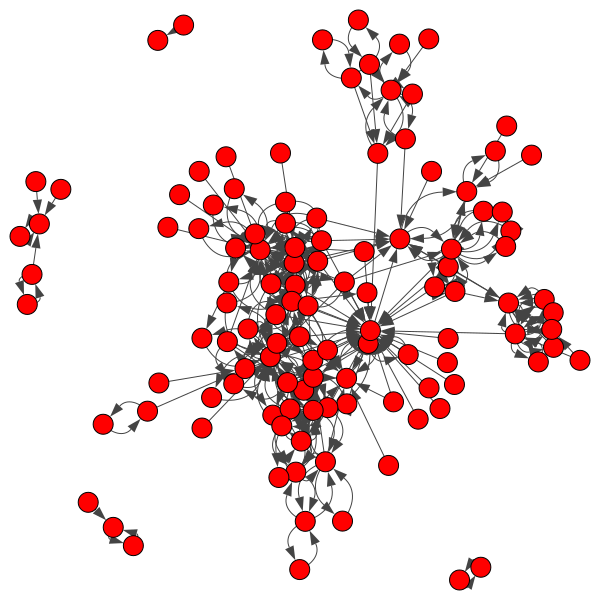

In [21]:
out = plot(Gm)
out.save('Outputs/Original_Amz.png')
out

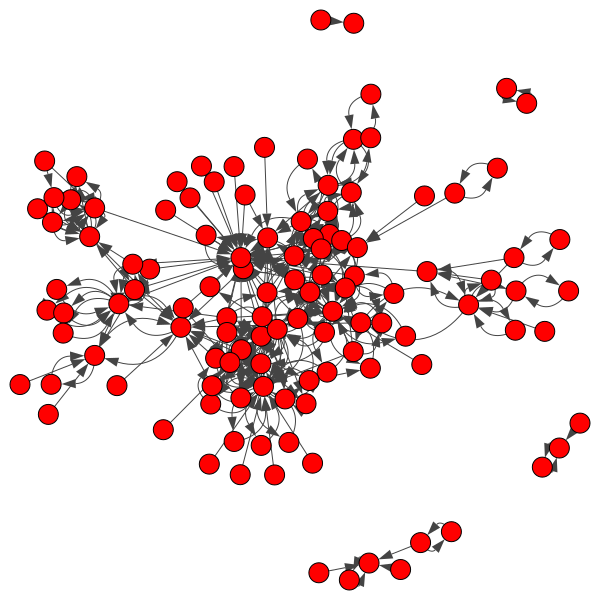

In [22]:
o=deGroot(adj_mat,s,10,0.00000001)

Reached equilibrium after 3 rounds.


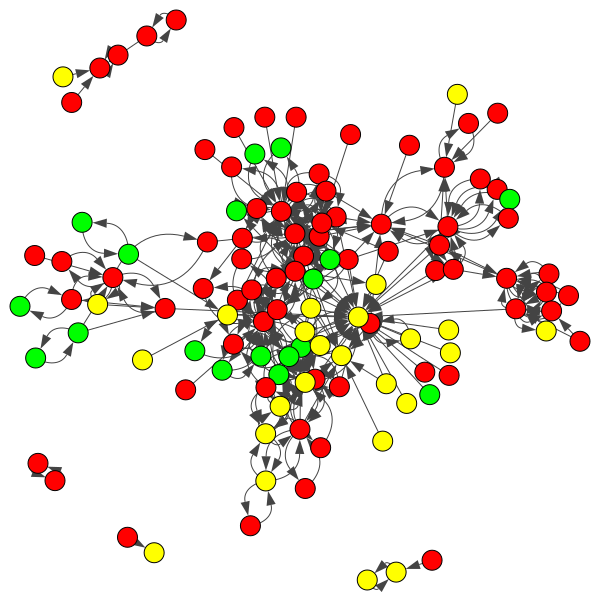

In [23]:
n=0
p=0
z=0
col = []
for i in range(0,160):
    if o[i][0]<=0 :
        col.append('red')
        n+=1
    elif o[i][0]>=0.5:
        col.append('green')
        p+=1
    elif o[i][0]>0 and s[i]<0.5:
        col.append('yellow')
        z+=1
Gm.vs['color'] = col
out = plot(Gm)
out.save('Outputs/1Degroot_Amz.png')
out

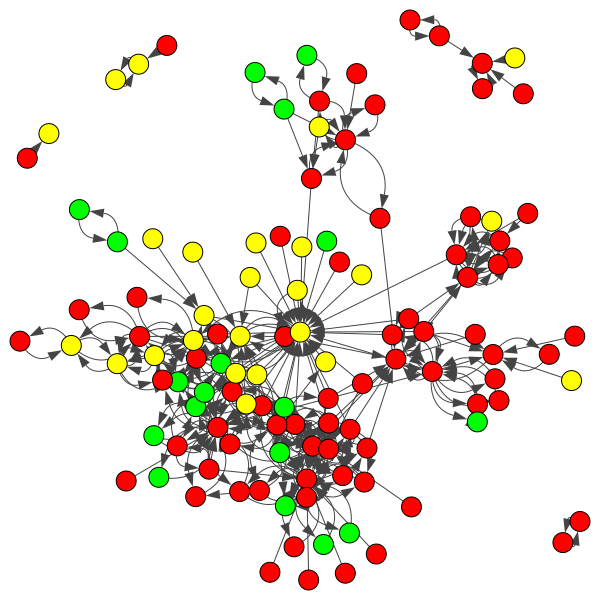

In [24]:
t=[n,p,z]
t

[102, 19, 39]

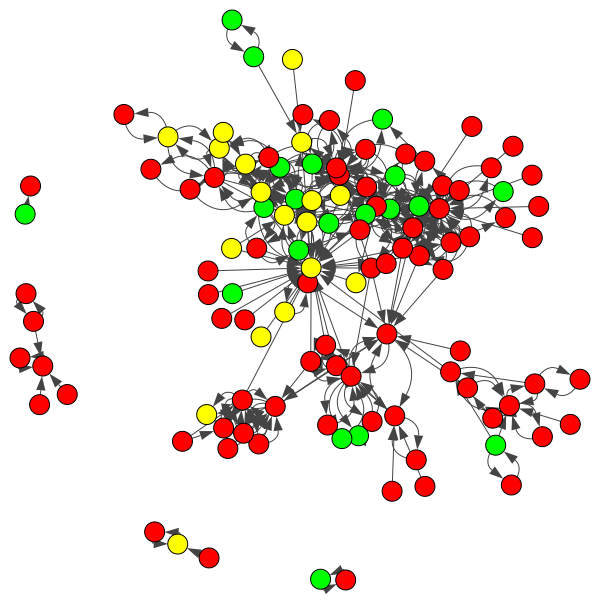

In [25]:
n=0
p=0
z=0
col = []
for i in range(0,160):
    if o[i][1]<=0 :
        col.append('red')
        n+=1
    elif o[i][1]>=0.5:
        col.append('green')
        p+=1
    elif o[i][1]>0 and s[i]<0.5:
        col.append('yellow')
        z+=1
Gm.vs['color'] = col
out = plot(Gm)
out.save('Outputs/2Degroot_Amz.png')
out

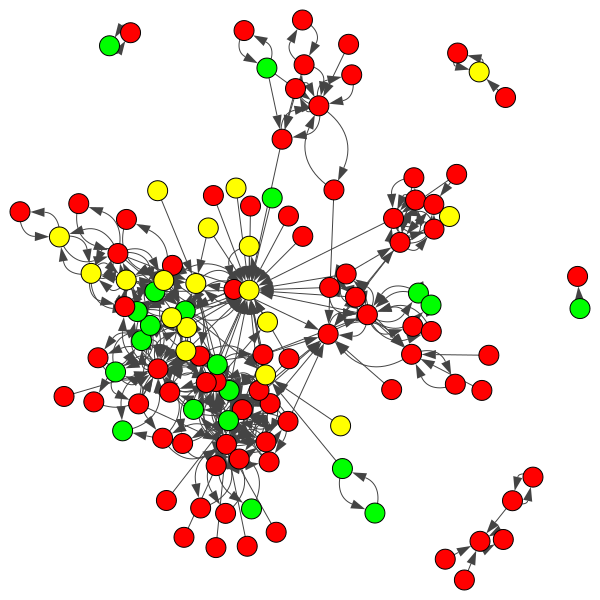

In [26]:
t=[n,p,z]
t

[106, 23, 31]

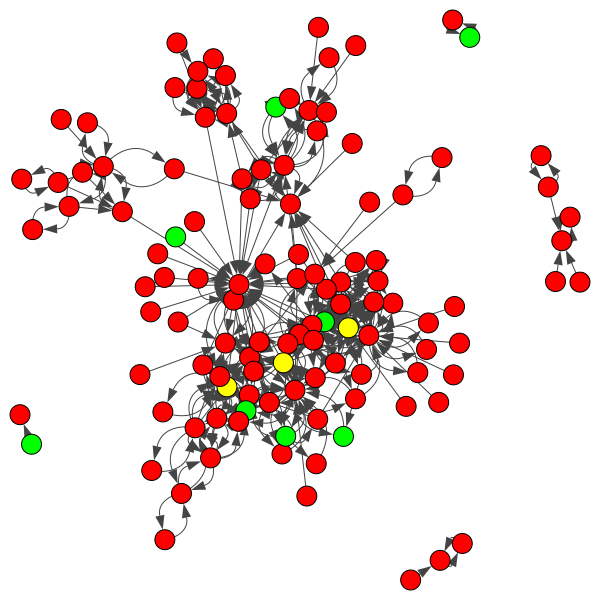

In [27]:
n=0
p=0
z=0
col = []
for i in range(0,160):
    if o[i][2]<=0 :
        col.append('red')
        n+=1
    elif o[i][2]>=0.5:
        col.append('green')
        p+=1
    elif o[i][2]>0 and s[i]<0.5:
        col.append('yellow')
        z+=1
Gm.vs['color'] = col
out = plot(Gm)
out.save('Outputs/3Degroot_Amz.png')
out

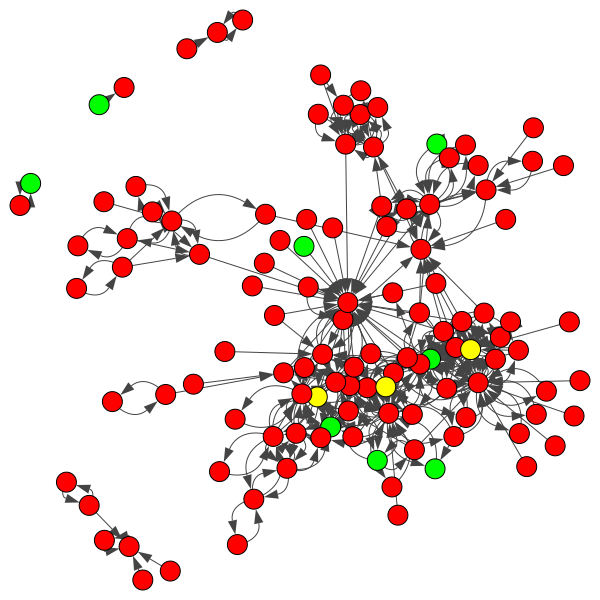

In [28]:
t=[n,p,z]
t

[149, 8, 3]

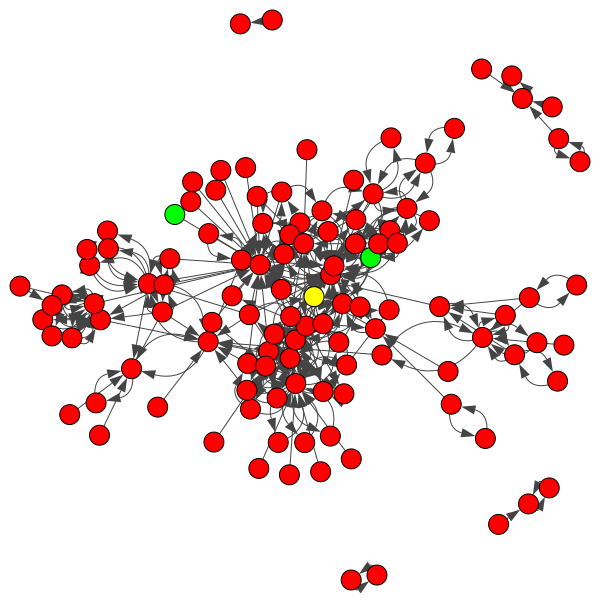

In [29]:
n=0
p=0
z=0
col = []
for i in range(0,160):
    if o[i][3]<=0 :
        col.append('red')
        n+=1
    elif o[i][3]>=0.5:
        col.append('green')
        p+=1
    elif o[i][3]>0 and s[i]<0.5:
        col.append('yellow')
        z+=1
Gm.vs['color'] = col
out = plot(Gm)
out.save('Outputs/4Degroot_Amz.png')
out

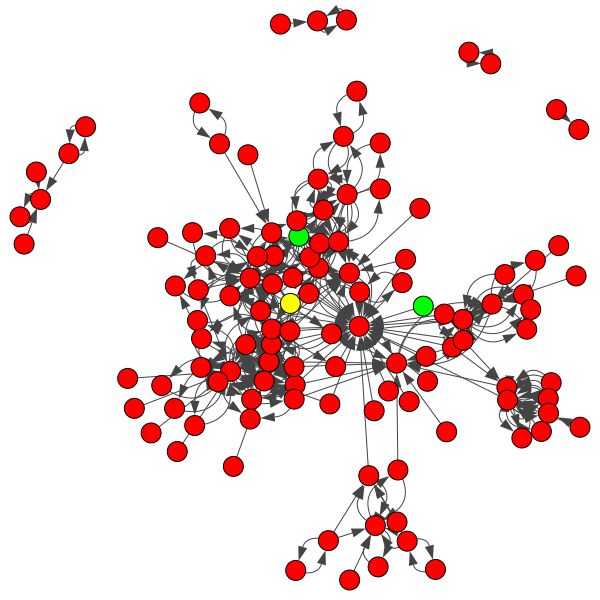

In [30]:
t=[n,p,z]
t

[157, 2, 1]

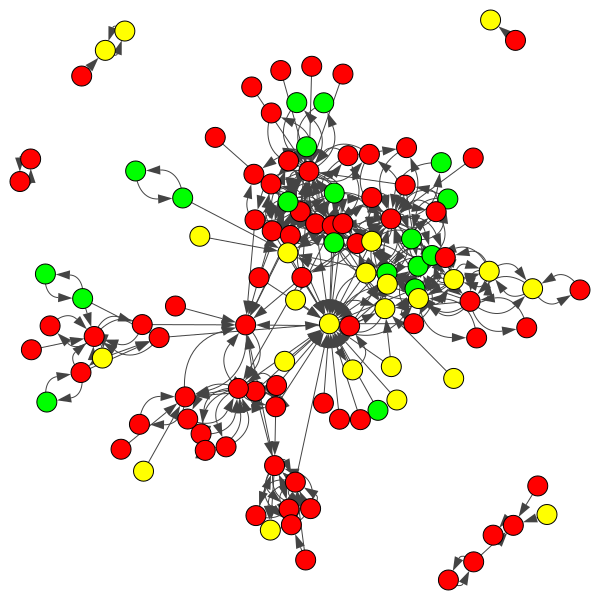

In [31]:
n=0
p=0
z=0
col = []
for i in range(0,160):
    if sf[i]<=0 :
        col.append('red')
        n+=1
    elif sf[i]>=0.5:
        col.append('green')
        p+=1
    elif sf[i]>0 and s[i]<0.5:
        col.append('yellow')
        z+=1
Gm.vs['color'] = col
out = plot(Gm)
out.save('Outputs/5Degroot_Amz.png')
out

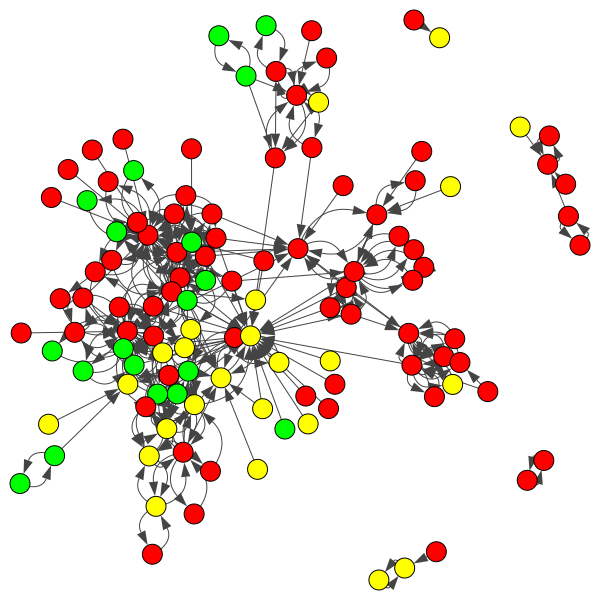

In [32]:
t=[n,p,z]
t

[102, 21, 37]

### Plots given below shows how the predictions are getting converged


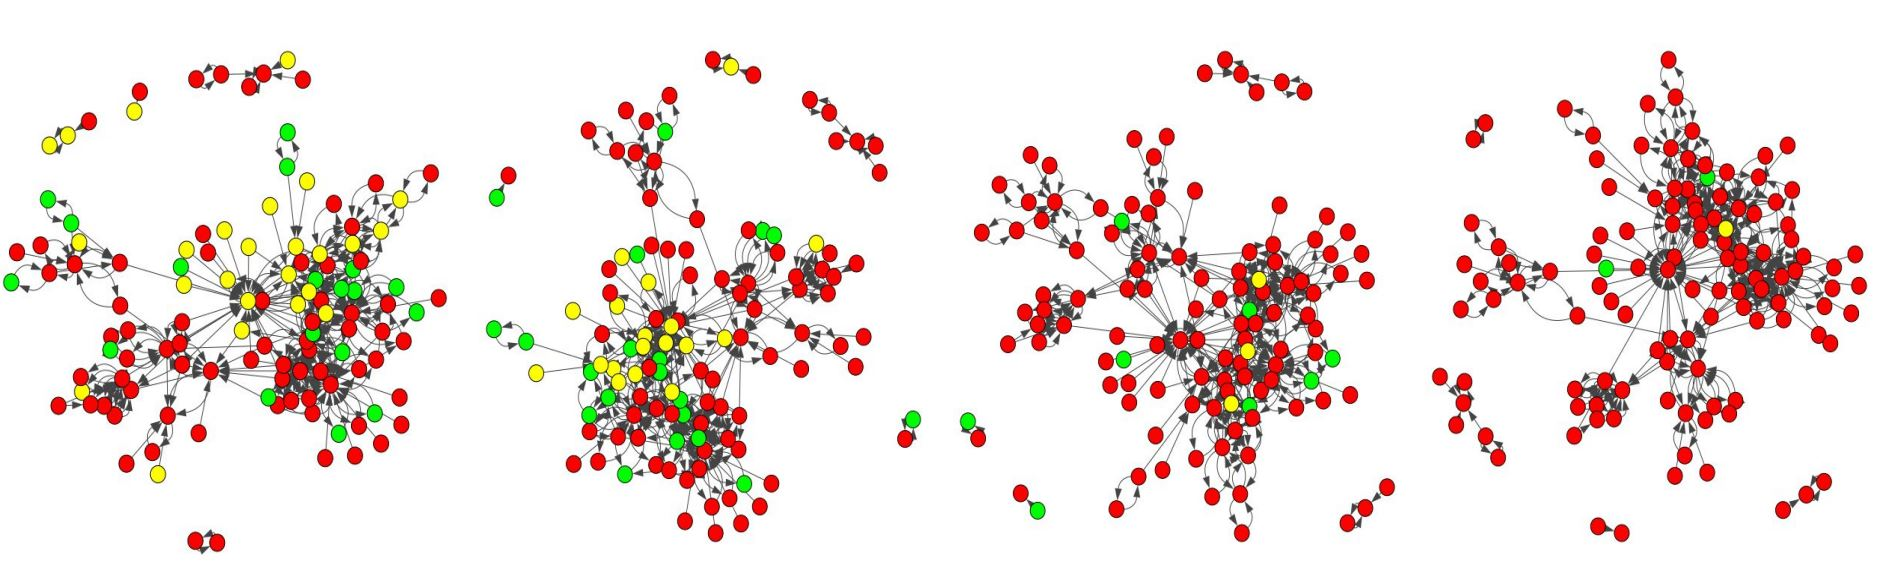

In [33]:
for i in range(len(o)):
    if o[i][3]<=0 :
        print("negative")
    elif o[i][3]>=0.5:
        print("positive")
    elif o[i][3]>0 and s[i]<0.5:
        print("neutral")
    
    print (text[i])

negative
It truly horrifies me that people would rather destroy the Earth than stop killing animals and have the audacity to say veganism is a cult AmazonFires
negative
It truly horrifies me that people would rather destroy the Earth than stop killing animals and have the audacity to say veganism is a cult AmazonFires
negative
It truly horrifies me that people would rather destroy the Earth than stop killing animals and have the audacity to say veganism is a cult AmazonFires
negative
It truly horrifies me that people would rather destroy the Earth than stop killing animals and have the audacity to say veganism is a cult AmazonFires
negative
Amazon fires Whats the latest in Brazil There are signs though that the situation is worse than it appears This is because the burning of the rainforest isnt the biggest problem  deforestation is AmazonFires CerradoSavannah deforestation  httpstcoRDX8B2mhKi
negative
MellowOchre ChildOfAlba According to the University of Oxford
Going Vegan is the sin